## Задание 3: расположение меток/подписей (label placement) 

На входе алгоритма набор пар целочисленных координат точек от 0 до 500, а также для каждой точки размеры подписи к ней (два целых числа — ширина и высота рамки подписи) и некоторое подмножество возможных расположений подписи (см. картинки справа). Кодирование входных данных — на ваш выбор, но лучше согласовать друг с другом в Телеграме, чтобы удобно было обмениваться примерами входных данных. 

На выходе — картинка с точками и неперекрывающимися метками (в частности, не вылезающими за пределы холста 500×500) либо указание, что такое расположение недостижимо. 

Задачу можно решать  

- либо в постановке, когда для каждой точки задан выбор не более чем из двух вариантов расположения подписи, и написать самостоятельно 2-SAT решатель,  

- либо без ограничений на количество вариантов, и тогда допустимо воспользоваться сторонним SAT-решателем, указав, как Вы кодируете задачу. 

## 2-SAT

### Импорт библиотек

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Создаем классы

In [7]:
class Pos:
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = arr
    
    def __add__(self, that):
        return [a + b for a, b in zip(self.xy, that.xy)]
    
    def __sub__(self, that):
        return [a - b for a, b in zip(self.xy, that.xy)]
    
    def __neg__(self):
        return [-a for a in self.xy]
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)


class Box:
    def __init__(self, line):
        arr = line.split('\t')
        self.pos = Pos.parse(arr[0])
        self.size = Pos.parse(arr[1])
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
        assert len(self.offsets) > 0
    
    def __str__(self):
        return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
        return str(self)

In [8]:
class LabelPlacement:
    def __init__(self, filename='', data=''):
        if data:
            self.data = data
        elif filename:
            with open(filename) as f:
                self.data = f.read()
        else:
            raise Exception("No argument filename or data")
    
    def get_boxes(self):
        result = []
        split_data = self.data.strip().split('\n')
        for line in split_data:
            result.append(Box(line))
        return result
    
    def rent_col(self, l1, r1, l2, r2):
        if (l1.xy[0] == r1.xy[0] or l1.xy[1] == r1.xy[1] or l2.xy[0] == r2.xy[0] or l2.xy[1] == r2.xy[1]):
            return False

        if(l1.xy[0] >= r2.xy[0] or l2.xy[0] >= r1.xy[0]):
            return False

        if(l1.xy[1] >= r2.xy[1] or l2.xy[1] >= r1.xy[1]):
            return False
        return True
    
    def is_collide(self, boxes, I, J):
        b1 = boxes[I]
        b2 = boxes[J]
        plc = [(0, 0), (0, 1), (1, 0), (1, 1)]
        pos1 = b1.pos
        pos2 = b2.pos
        size1 = b1.size
        size2 = b2.size
        cols = []
        for i, j in plc:
            b1_off = b1.offsets[i]
            b2_off = b2.offsets[j]
            l1 = Pos(*(pos1 - b1_off))
            l2 = Pos(*(pos2 - b2_off))
            r1 = Pos(*(l1 + size1))
            r2 = Pos(*(l2 + size2))
            if self.rent_col(
                l1, r1, l2, r2
            ):
                cols.append((i, j))
        return cols
    
    def make_cond(self, cond, I, J):
        return lambda x: (cond[0] + x[I]) % 2 or (cond[1] + x[J]) % 2
    
    def get_funcs(self, boxes):
        funcs = []
        n = len(boxes)
        for i in range(n):
            for j in range(i+1, n):
                bad_poses = self.is_collide(boxes, i, j)
                for pos in bad_poses:
                    funcs.append(self.make_cond(pos, i, j))
        return funcs
    
    def find_optim(self, funcs, n):
        for i in range(2 ** n):
            places = [int(x) for x in bin(i)[2:].zfill(n)]
            res = 1
            for f in funcs:
                res *= f(places)
            if res == 1:
                break
        return res, places
    
    def plotting_data(self, boxes, poses):
        coord = []
        sizes = []
        labels = []
        for i, box in enumerate(boxes):
            coord.append(box.pos.xy)
            sizes.append(box.size.xy)
            label = box.pos - box.offsets[poses[i]]
            labels.append(label)
        return coord, sizes, labels
    
    def draw(self):
        boxes = self.get_boxes()
        n = len(boxes)
        res, places = self.find_optim(self.get_funcs(boxes), n)
        if res:
            fig, ax = plt.subplots(dpi=100, figsize=(10, 10))
            dots, sizes, labels = self.plotting_data(boxes, places)
            for i in range(n):
                ax.add_patch(Rectangle(labels[i], sizes[i][0], sizes[i][1],
                         edgecolor = 'blue',
                         fill=False,
                         lw=2))
                ax.scatter(*dots[i], color='#ff0', s=200)
                text_coord = (labels[i][0] + (sizes[i][0]/2 - 1/20), labels[i][1] + (sizes[i][1]/2 - 2/20))
                ax.annotate(str(i), dots[i], xytext=text_coord)
            plt.show()
        else:
            print("No optimal way")

### Загрузка файлов

In [11]:
!git clone https://github.com/SergeyMalyshevsky/FilesForDataVisualization.git

Cloning into 'FilesForDataVisualization'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 8), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [12]:
!ls FilesForDataVisualization

hw02-dag-0.graphml       hw03-bin-1.txt           tree-60n.xml
hw02-dag-1.graphml       hw03-bin-2.txt           tree-72n.xml
hw02-dag-13n-lection.xml hw03-bin-3.txt           tree-84n.xml
hw02-dag-44n.xml         hw03-bin-4.txt
hw02-dag-92n.xml         tree-42n.xml


### Проверка

In [13]:
no_way_data = '''
20,20	10,10	0,0 0,10 10,10
20,25	10,10	0,0 10,0 0,10 10,10
25,20	10,10	10,0 10,10
25,25	10,10	10,0 0,10
'''

lp = LabelPlacement(data=no_way_data)
lp.draw()

No optimal way


In [14]:
lp_1 = LabelPlacement(filename="FilesForDataVisualization/hw03-bin-1.txt")

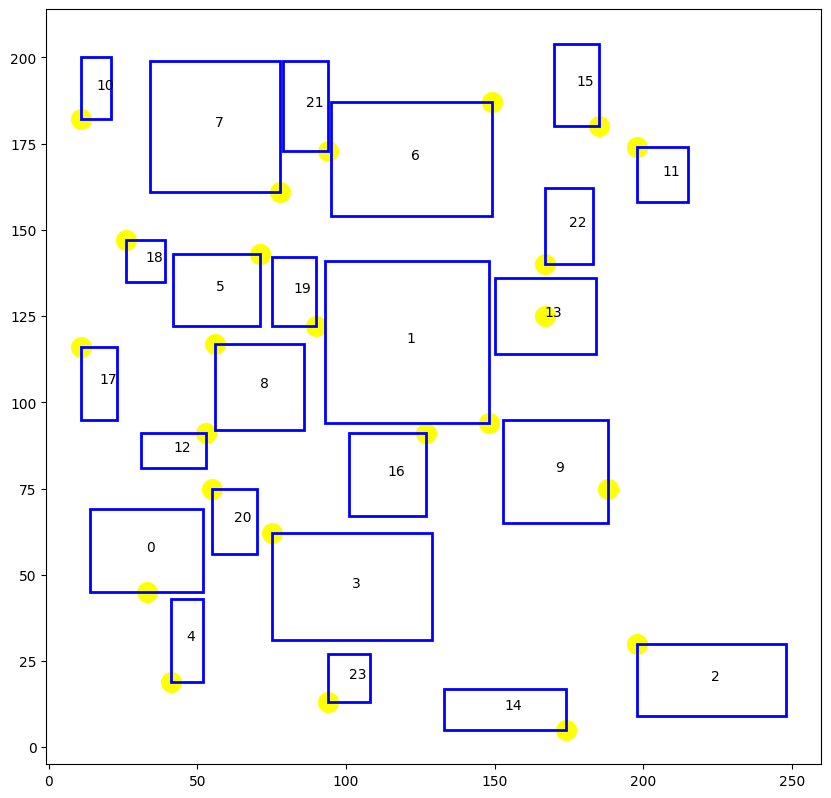

CPU times: user 1min 7s, sys: 78.9 ms, total: 1min 7s
Wall time: 1min 7s


In [15]:
%%time
lp_1.draw()

In [16]:
lp_2 = LabelPlacement(filename="FilesForDataVisualization/hw03-bin-2.txt")

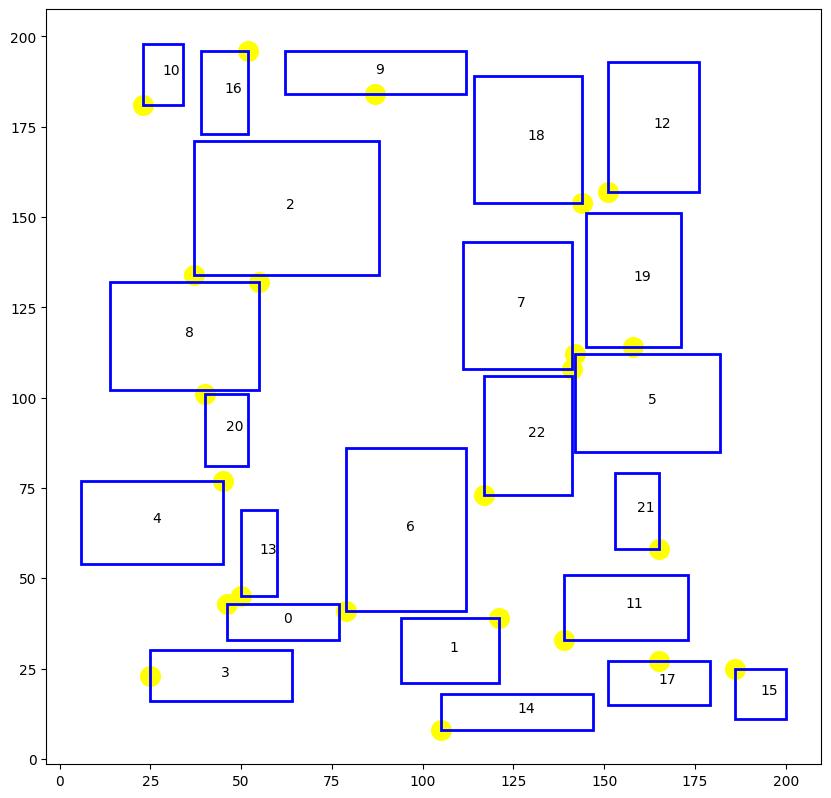

CPU times: user 32.2 s, sys: 31.3 ms, total: 32.2 s
Wall time: 32.2 s


In [17]:
%%time
lp_2.draw()

In [18]:
lp_3 = LabelPlacement(filename="FilesForDataVisualization/hw03-bin-3.txt")

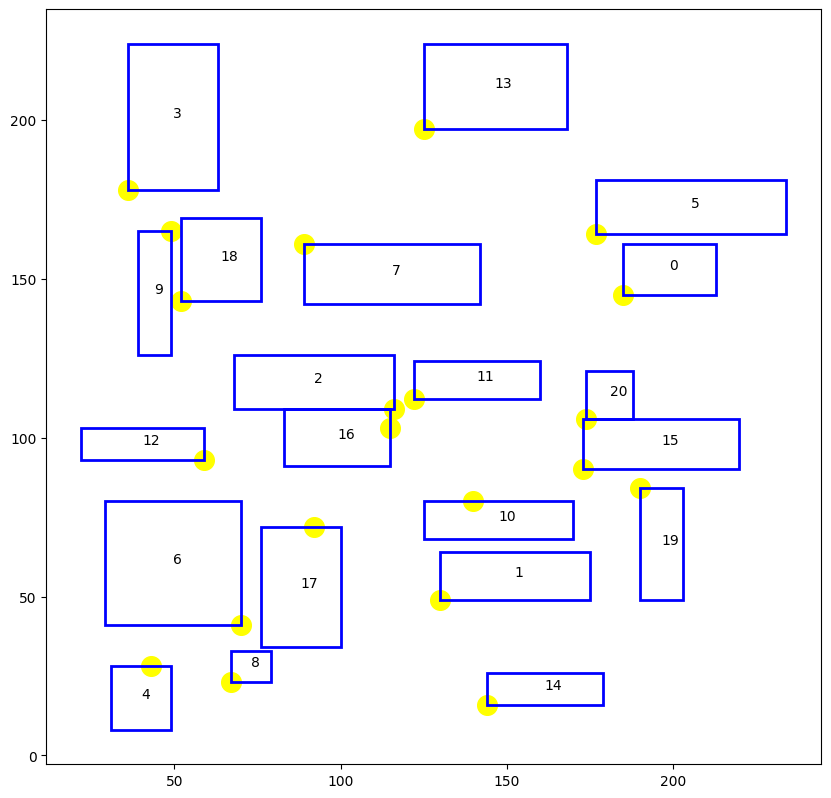

CPU times: user 3.71 s, sys: 21.8 ms, total: 3.73 s
Wall time: 3.74 s


In [19]:
%%time
lp_3.draw()

In [20]:
lp_4 = LabelPlacement(filename="FilesForDataVisualization/hw03-bin-4.txt")

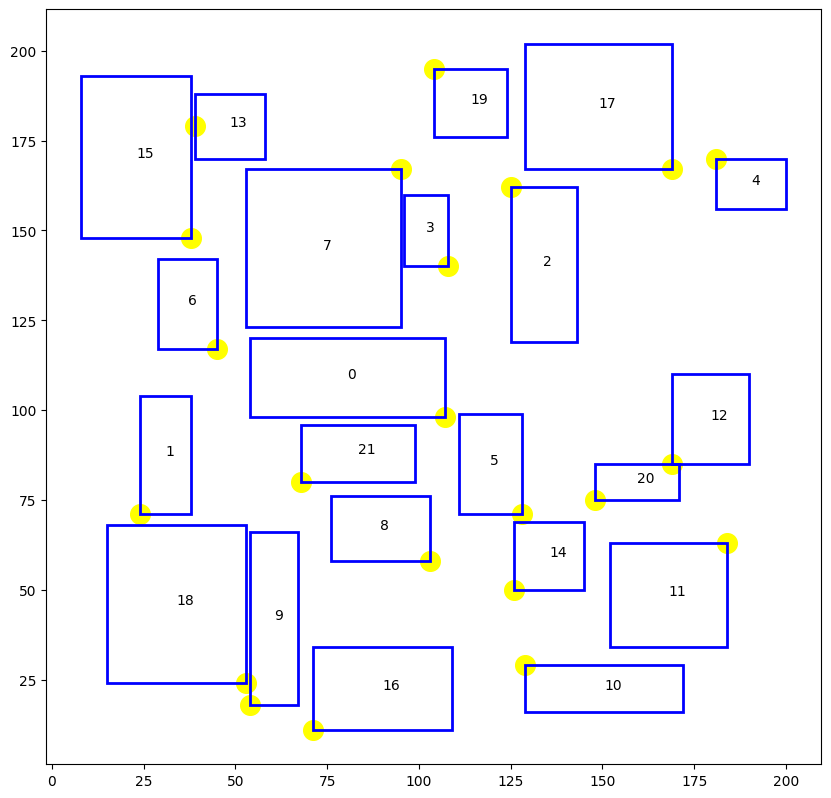

CPU times: user 28 s, sys: 34.9 ms, total: 28.1 s
Wall time: 28.1 s


In [21]:
%%time
lp_4.draw()